In this notebook I am only interested in plotting basic data agregated by countries for the main occidental countries.

In [1]:
import sys
from IPython.display import display

sys.path.append('../')

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd

%matplotlib inline

In [3]:
from definitions import DATA_DIR, ROOT_DIR, DATA_FILE
from covid.data_download import download_data_from_kaggle
from covid.plotting import plot_by_country
from covid.processing import get_start_date, filter_by_trigger_date, filter_data_by_countries

In [4]:
download_data_from_kaggle()
downloaded_files = list((ROOT_DIR / DATA_DIR).glob('*.csv'))

print(f"Downloaded files:\n{chr(10).join(str(f.name) for f in downloaded_files)}")

100%|██████████| 105k/105k [00:00<00:00, 4.80MB/s]


Downloaded files:
covid_19_clean_complete.csv


In [5]:
data_fname = ROOT_DIR / DATA_DIR / DATA_FILE

In [6]:
data_raw = pd.read_csv(data_fname, parse_dates=['Date'])
data_raw.sample(10)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
737,Virginia,US,37.7693,-78.1700,2020-01-24,0.0,0.0,0.0
7611,Beijing,China,40.1824,116.4142,2020-02-15,375.0,4.0,98.0
14935,NaN,Azerbaijan,40.1431,47.5769,2020-03-10,11.0,0.0,0.0
8061,NaN,Japan,36.0000,138.0000,2020-02-17,66.0,1.0,12.0
18928,NaN,Spain,40.0000,-4.0000,2020-03-23,28768.0,1772.0,2575.0
14360,California,US,36.1162,-119.6816,2020-03-08,0.0,0.0,0.0
4235,Saint Barthelemy,France,17.9000,-62.8333,2020-02-04,0.0,0.0,0.0
3525,South Carolina,US,33.8569,-80.9450,2020-02-02,0.0,0.0,0.0
570,NaN,Barbados,13.1939,-59.5432,2020-01-23,0.0,0.0,0.0
2581,Massachusetts,US,42.2302,-71.5301,2020-01-30,0.0,0.0,0.0


I will drop the `Province/State`, `Lat`, `Long`.
For countries with a mainland and other territories (France and United Kingdom), I will keep the mainland. In the future, I may select some States form the USA.

In [7]:
rename_dict = {'Province/State': 'state', 'Country/Region': 'country', 'Confirmed': 'cases', 'Fatalities': 'deaths'}
data_raw = data_raw.rename(columns=rename_dict).rename(columns=lambda x: x.lower())

data_raw.columns

Index(['state', 'country', 'lat', 'long', 'date', 'cases', 'deaths',
       'recovered'],
      dtype='object')

## Latest available date

In [8]:
display(f"Latest available date in dataset: {data_raw['date'].max().strftime('%d/%m/%Y')}")

'Latest available date in dataset: 23/03/2020'

## Reduce country list here

In [9]:
# list of countries where only mainland is selected
countries_mainland = ['France', 'Italy', 'Germany', 'Sweden', 'United Kingdom', 'Norway', 'Spain', 'Belgium']
# list of countries that with multiple states will be aggregated by summing
countries_with_states = ['US']
# list of states to be considered as countries
single_states = ['Washington', 'New York', 'California', 'Hubei']

data = filter_data_by_countries(data_raw, countries=countries_mainland, countries_with_states=countries_with_states, states=single_states)

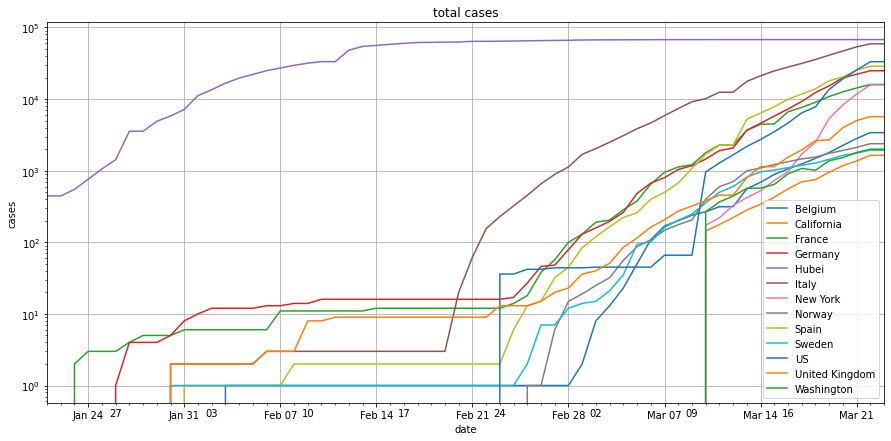

In [10]:
plot_by_country(data, 'cases', 'total cases', logy=True)

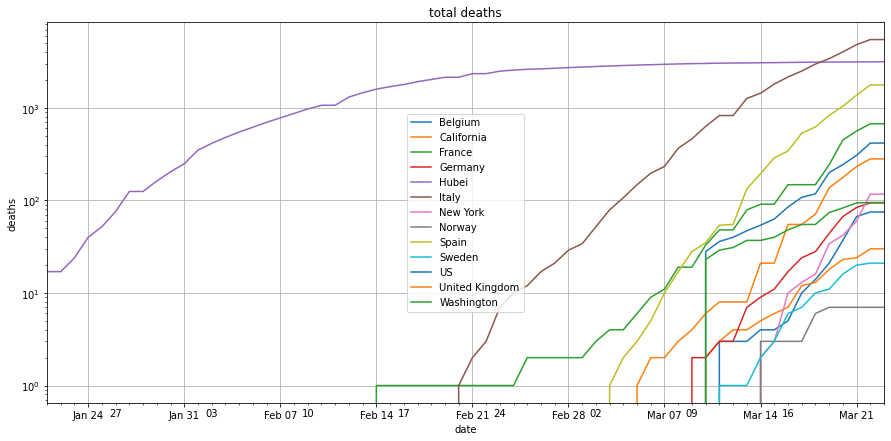

In [11]:
plot_by_country(data, 'deaths', 'total deaths', logy=True)

# Trigger date is when 100 cases are declared

In this section, for each country, day 0 is the day they had 100 cases.

Offsetting by this date, I plot the evolution of `cases` and `deaths`.

Keep in mind that some countries do more systematic checks (even of apparently healthy people) while others only check patients arriving at hospital with serious condition.

In [12]:
threshold = 100
case_trigger = get_start_date(data, 'cases', threshold=threshold)
display(case_trigger)

country
Belgium          2020-03-06
California       2020-03-10
France           2020-02-29
Germany          2020-03-01
Hubei            2020-01-22
Italy            2020-02-23
New York         2020-03-10
Norway           2020-03-06
Spain            2020-03-02
Sweden           2020-03-06
US               2020-03-10
United Kingdom   2020-03-05
Washington       2020-03-10
Name: cases_trigger_date, dtype: datetime64[ns]

### Below is the offset for death trigger date compared to Italy (reference date)

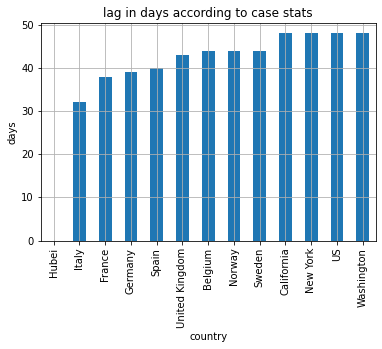

In [13]:
case_lags = case_trigger.apply(lambda x: x - case_trigger.min())
ax = case_lags.sort_values().astype('timedelta64[D]').rename('days').plot(kind='bar', grid=True, title='lag in days according to case stats')
ax.set(ylabel='days')
plt.show()

In [14]:
case_offset_data = filter_by_trigger_date(data, 'cases', threshold=threshold)
case_offset_data

,country,cases,deaths
date,,,
0 days,Belgium,109.0,0.0
1 days,Belgium,169.0,0.0
2 days,Belgium,200.0,0.0
3 days,Belgium,239.0,0.0
4 days,Belgium,267.0,0.0
...,...,...,...
9 days,Washington,1376.0,74.0
10 days,Washington,1524.0,83.0
11 days,Washington,1793.0,94.0


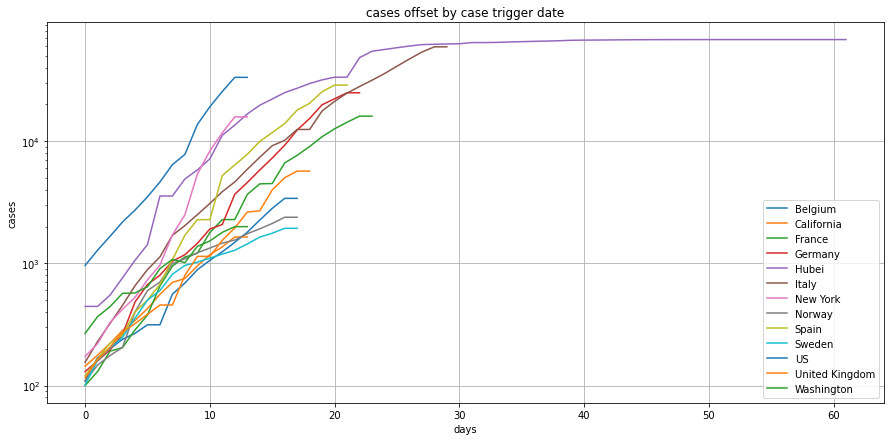

In [15]:
ax = plot_by_country(case_offset_data, 'cases', title='cases offset by case trigger date', logy=True)

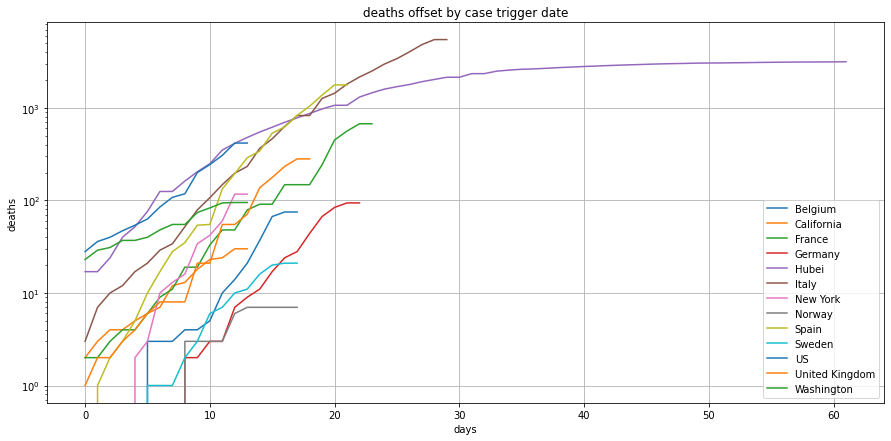

In [16]:
plot_by_country(case_offset_data, 'deaths', title='deaths offset by case trigger date', logy=True)

# Trigger date is when 5 deaths are declared
(5 because for the moment Norway has a maximum of 7 deaths in the dataset)

In this section, for each country, day 0 is the day they had 5 deaths.

Offsetting by this date, I plot the evolution of `cases` and `deaths`.

The reason I am looking at offsetting by death trigger date, is that the way different countries identify and count deaths is very similar, while for counting cases, some countries do systematic checks (leading to a low apparent mortality) and others check only serious cases ending in hospital (leading to a high apparent mortality)

In [17]:
((case_offset_data.index / pd.Timedelta(1, 'd')).astype(int)).name = 'toto'

In [18]:
threshold = 5
death_trigger = get_start_date(data, 'deaths', threshold=threshold)
display(death_trigger)

country
Belgium          2020-03-16
California       2020-03-14
France           2020-03-05
Germany          2020-03-13
Hubei            2020-01-22
Italy            2020-02-24
New York         2020-03-16
Norway           2020-03-18
Spain            2020-03-06
Sweden           2020-03-16
US               2020-03-10
United Kingdom   2020-03-10
Washington       2020-03-10
Name: deaths_trigger_date, dtype: datetime64[ns]

### Below is the offset for death trigger date compared to Italy (reference date)

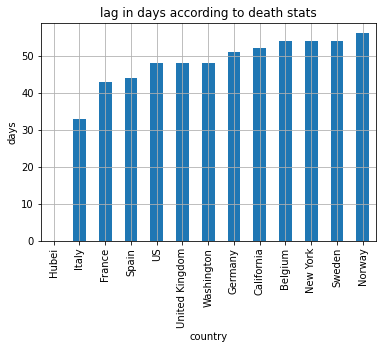

In [19]:
death_lags = death_trigger.apply(lambda x: x - death_trigger.min())
ax = death_lags.sort_values().astype('timedelta64[D]').rename('days').plot(kind='bar', grid=True, title='lag in days according to death stats')
ax.set(ylabel='days')
plt.show()

In [20]:
death_offset_data = filter_by_trigger_date(data, 'deaths', threshold=threshold)
death_offset_data

,country,cases,deaths
date,,,
0 days,Belgium,1058.0,5.0
1 days,Belgium,1243.0,10.0
2 days,Belgium,1486.0,14.0
3 days,Belgium,1795.0,21.0
4 days,Belgium,2257.0,37.0
...,...,...,...
9 days,Washington,1376.0,74.0
10 days,Washington,1524.0,83.0
11 days,Washington,1793.0,94.0


### lags between countries

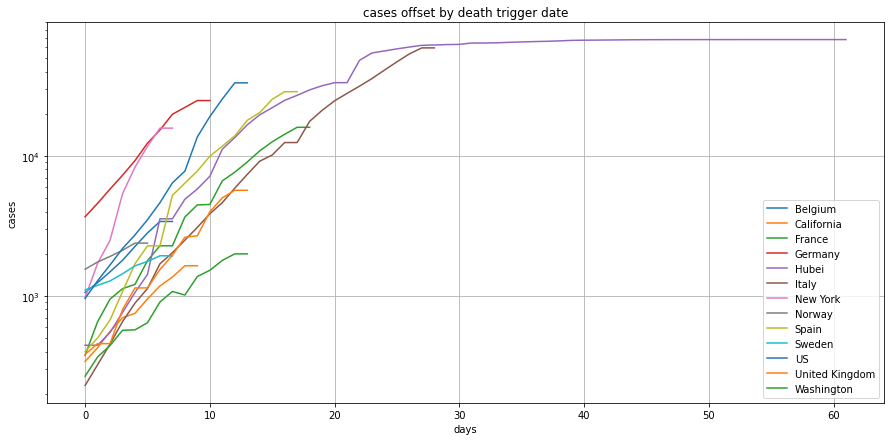

In [21]:
plot_by_country(death_offset_data, 'cases', title='cases offset by death trigger date', logy=True)

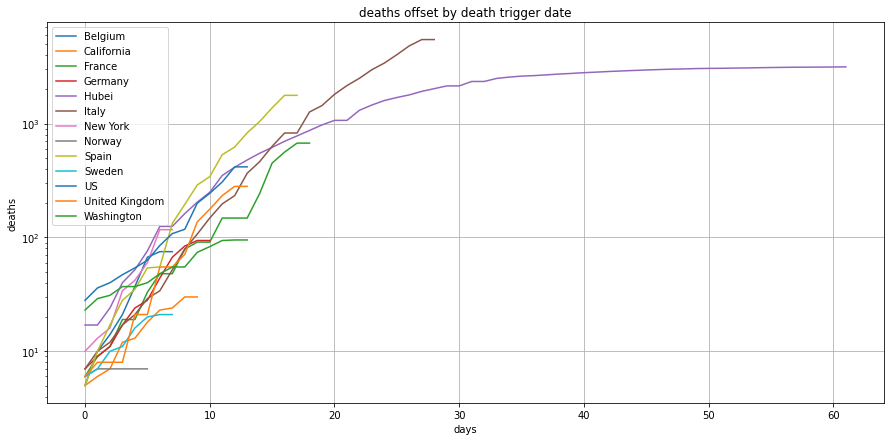

In [22]:
plot_by_country(death_offset_data, 'deaths', title='deaths offset by death trigger date', logy=True)

# Ideas:
- mitigate with population size, density